In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import imblearn.over_sampling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_curve, roc_auc_score, classification_report, precision_recall_curve, f1_score
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import LabelEncoder
import warnings 
warnings.filterwarnings(action= 'ignore')

# EDA 

Starting by joining the Billboard top 100 dataset and the Spotify dataset

## Importing Spotify dataset

In [57]:
spotify_songs = pd.read_csv('all_songs_data.csv')

#cleaning the artist and songs columns to match with the billboard data set

spotify_songs['Artist'] = spotify_songs['Artist'].str.lstrip("&").str.lower().str.replace(' ','')

spotify_songs['Song'] = spotify_songs['Song'].str.lower()

#check the shape
spotify_songs.shape

(13377, 22)

## Removing Duplicates

sometimes the song can appear in diffrent playlists so we need to remove the duplicated songs by their IDs 

In [58]:
#check for duplicate songs 
spotify_songs['Id'].nunique()

13006

In [59]:
#lets drop them
spotify_songs= spotify_songs.drop_duplicates(subset=['Id'])

#Done..
spotify_songs.shape

(13006, 22)

## Importing Billboard dataset

In [60]:
billboard_charts = pd.read_csv('100_charts.csv')

#drop columns we dont need 
billboard_charts = billboard_charts.drop(['Unnamed: 0','Date'],axis = 1)

billboard_charts.shape

(330587, 3)

In [61]:
billboard_charts_grouped = pd.DataFrame(billboard_charts.groupby(['artist','song'],as_index=False)['peakPos_'].min())
billboard_charts_grouped

artist  \
0                                        "Groove" Holmes   
1                                        "Groove" Holmes   
2                                 "Little" Jimmy Dickens   
3                                        "Pookie" Hudson   
4                                    "Weird Al" Yankovic   
...                                                  ...   
29655                            will.i.am & Nicki Minaj   
29656                  will.i.am Featuring Justin Bieber   
29657   will.i.am Featuring Mick Jagger & Jennifer Lopez   
29658                    will.i.am Featuring Miley Cyrus   
29659  will.i.am Featuring Miley Cyrus, French Montan...   

                                            song  peakPos_  
0                                          Misty        44  
1                               What Now My Love        96  
2      May The Bird Of Paradise Fly Up Your Nose        15  
3                                  I Know I Know        96  
4                                 Amish Paradise        53  
...                                          ...       ...  
29655                               Check It Out        24  
29656                                 #thatPOWER        17  
29657                   T.H.E (The Hardest Ever)        36  
29658                                  Fall Down        58  
29659                             Feelin' Myself        96  

[29660 rows x 3 columns]

In [62]:
# Clean the billboard columns because it is a mess to match with the columns in the spotify dataset 

billboard_charts_grouped['artist'] = billboard_charts_grouped['artist'].str.lower().str.replace('featuring','&').str.replace('ft.','&').str.replace('ft','&').str.replace('feature','&').str.replace('feat.','&').str.replace('feat','&').str.replace('+','&').str.replace('with','&').str.replace('/','&').str.replace(',','&').str.replace(' ','')\
.str.replace('(','').str.replace(')','')

billboard_charts_grouped['song'] = billboard_charts_grouped['song'].str.lower()

billboard_charts_grouped.head()

artist                                       song  peakPos_
0        "groove"holmes                                      misty        44
1        "groove"holmes                           what now my love        96
2  "little"jimmydickens  may the bird of paradise fly up your nose        15
3        "pookie"hudson                              i know i know        96
4     "weirdal"yankovic                             amish paradise        53

## Merging 

we have the *song* and *artist* from the billborad and we have *Song* and *Artist* from the Spotify dataset.. so we will merge on them lets call it *hit_songs*

In [63]:
hit_songs = pd.merge(billboard_charts_grouped,spotify_songs, how='inner', left_on=['song','artist'], right_on = ['Song','Artist'])

hit_songs.head()

artist                song  peakPos_  Unnamed: 0                Song  \
0  10years           wasteland        94        1708           wasteland   
1     10cc   dreadlock holiday        44        1940   dreadlock holiday   
2     10cc   dreadlock holiday        44        2771   dreadlock holiday   
3     10cc  good morning judge        69        2660  good morning judge   
4     10cc    i'm mandy fly me        60        2593    i'm mandy fly me   

    Artist                      Id  danceability  energy  key  ...  liveness  \
0  10years  0nTiC2fGkM4q8bGlBKGrGx         0.404   0.797  6.0  ...    0.0824   
1     10cc  5SI6jYhKUWm1qnaheTm4Zw         0.837   0.380  7.0  ...    0.1980   
2     10cc  1LOZMYF5s8qhW7Rv4w2gun         0.837   0.380  7.0  ...    0.1980   
3     10cc  1fMGRxKRtIKNyaMMGrzInM         0.737   0.642  9.0  ...    0.0726   
4     10cc  4mmWv18Tz155oy6x7PEe3q         0.426   0.546  7.0  ...    0.0966   

   valence    tempo            type                      id  \
0    0.361  146.580  audio_features  0nTiC2fGkM4q8bGlBKGrGx   
1    0.892  104.995  audio_features  5SI6jYhKUWm1qnaheTm4Zw   
2    0.892  104.995  audio_features  1LOZMYF5s8qhW7Rv4w2gun   
3    0.467  106.742  audio_features  1fMGRxKRtIKNyaMMGrzInM   
4    0.440  107.885  audio_features  4mmWv18Tz155oy6x7PEe3q   

                                    uri  \
0  spotify:track:0nTiC2fGkM4q8bGlBKGrGx   
1  spotify:track:5SI6jYhKUWm1qnaheTm4Zw   
2  spotify:track:1LOZMYF5s8qhW7Rv4w2gun   
3  spotify:track:1fMGRxKRtIKNyaMMGrzInM   
4  spotify:track:4mmWv18Tz155oy6x7PEe3q   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/0nTiC2fGkM4q...   
1  https://api.spotify.com/v1/tracks/5SI6jYhKUWm1...   
2  https://api.spotify.com/v1/tracks/1LOZMYF5s8qh...   
3  https://api.spotify.com/v1/tracks/1fMGRxKRtIKN...   
4  https://api.spotify.com/v1/tracks/4mmWv18Tz155...   

                                        analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/0nTi...    229973.0   
1  https://api.spotify.com/v1/audio-analysis/5SI6...    267947.0   
2  https://api.spotify.com/v1/audio-analysis/1LOZ...    267947.0   
3  https://api.spotify.com/v1/audio-analysis/1fMG...    174667.0   
4  https://api.spotify.com/v1/audio-analysis/4mmW...    323533.0   

  time_signature  
0            4.0  
1            4.0  
2            4.0  
3            4.0  
4            3.0  

[5 rows x 25 columns]

In [64]:
hit_songs.drop(['Unnamed: 0','Song','Artist','Id'],axis = 1,inplace = True)

## Labeling 

we need to add a new column called *Hit or not* that will check if the song's ID is on the *hit_Songs* then add a label 1 (Hit)
otherwise add 0 (Not Hit)

In [65]:
hit_id = list(hit_songs['id'])

In [66]:
# Now getting the not hit songs :

spotify_songs['Hit or not'] = np.where(spotify_songs['Id'].isin(hit_id), '1', '0')

spotify_songs = spotify_songs.drop(['Unnamed: 0','Id'],axis=1)

In [67]:
spotify_songs = spotify_songs.dropna()

In [68]:
spotify_songs = spotify_songs.astype({'Hit or not': 'int32'})
spotify_songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13003 entries, 0 to 13376
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Song              13003 non-null  object 
 1   Artist            13003 non-null  object 
 2   danceability      13003 non-null  float64
 3   energy            13003 non-null  float64
 4   key               13003 non-null  float64
 5   loudness          13003 non-null  float64
 6   mode              13003 non-null  float64
 7   speechiness       13003 non-null  float64
 8   acousticness      13003 non-null  float64
 9   instrumentalness  13003 non-null  float64
 10  liveness          13003 non-null  float64
 11  valence           13003 non-null  float64
 12  tempo             13003 non-null  float64
 13  type              13003 non-null  object 
 14  id                13003 non-null  object 
 15  uri               13003 non-null  object 
 16  track_href        13003 non-null  object

In [71]:
new = spotify_songs['Artist'].str.split("&", n = 2, expand = True)

spotify_songs['Artist1']= new[0]
 
spotify_songs['Artist2']= new[1]

spotify_songs['Artist3']= new[2]

spotify_songs.drop(columns =["Artist"], inplace = True)


In [73]:
le = LabelEncoder()
spotify_songs['Artist1'] = le.fit_transform(spotify_songs['Artist1'])
spotify_songs['Artist2'] = le.fit_transform(spotify_songs['Artist2'])
spotify_songs['Artist3'] = le.fit_transform(spotify_songs['Artist3'])
spotify_songs.head()

Song  danceability  energy   key  \
0               here comes the sun - remastered         0.557   0.540   9.0   
1                      when a man loves a woman         0.526   0.436   1.0   
2  (i can't get no) satisfaction - mono version         0.731   0.837   9.0   
3                      (what a) wonderful world         0.691   0.507  11.0   
4                               brown eyed girl         0.491   0.583   7.0   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  ...  \
0   -10.484   1.0       0.0347      0.033900          0.002480    0.1790  ...   
1    -6.020   1.0       0.0232      0.098100          0.000008    0.1180  ...   
2    -8.673   1.0       0.0477      0.000287          0.150000    0.0978  ...   
3   -10.230   1.0       0.0343      0.627000          0.000000    0.4570  ...   
4   -10.964   1.0       0.0376      0.185000          0.000000    0.4060  ...   

                       id                                   uri  \
0  45yEy5WJywhJ3sDI28ajTm  spotify:track:45yEy5WJywhJ3sDI28ajTm   
1  0GVxSbigOiKlGfI30Uw00X  spotify:track:0GVxSbigOiKlGfI30Uw00X   
2  5FKkbyGm42hw1y08l2knlO  spotify:track:5FKkbyGm42hw1y08l2knlO   
3  2g2GkH3vZHk4lWzBjgQ6nY  spotify:track:2g2GkH3vZHk4lWzBjgQ6nY   
4  3yrSvpt2l1xhsV9Em88Pul  spotify:track:3yrSvpt2l1xhsV9Em88Pul   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/45yEy5WJywhJ...   
1  https://api.spotify.com/v1/tracks/0GVxSbigOiKl...   
2  https://api.spotify.com/v1/tracks/5FKkbyGm42hw...   
3  https://api.spotify.com/v1/tracks/2g2GkH3vZHk4...   
4  https://api.spotify.com/v1/tracks/3yrSvpt2l1xh...   

                                        analysis_url duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/45yE...    185733.0   
1  https://api.spotify.com/v1/audio-analysis/0GVx...    175693.0   
2  https://api.spotify.com/v1/audio-analysis/5FKk...    222747.0   
3  https://api.spotify.com/v1/audio-analysis/2g2G...    125440.0   
4  https://api.spotify.com/v1/audio-analysis/3yrS...    183307.0   

  time_signature Hit or not  Artist1  Artist2  Artist3  
0            4.0          0     3759     1449      532  
1            3.0          1     2979     1449      532  
2            4.0          0     3985     1449      532  
3            4.0          0     3322     1449      532  
4            4.0          1     4256     1449      532  

[5 rows x 23 columns]

## Get a look into the data

As shown in the graph below, we can clearly see that class 0 ( Not hit ) have higher density than class 1 (Hit) and thats because of imbalance dataset ..

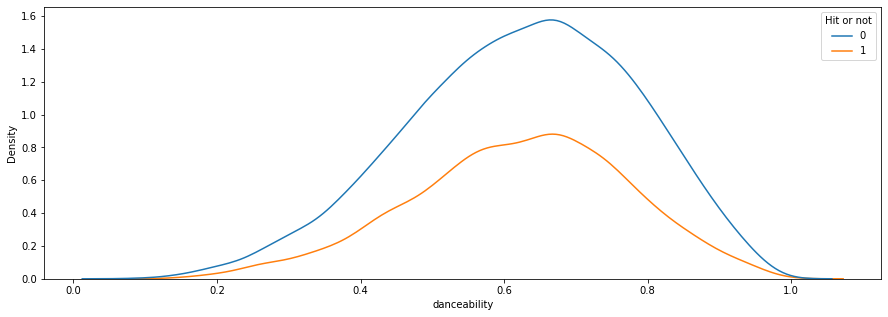

In [74]:
plt.figure(figsize=(15,5))
sns.kdeplot(data=spotify_songs, x="danceability", hue="Hit or not");


As we can see, the 0 (not Hit) class is almost double the 1 (Hit) class

In [75]:
spotify_songs['Hit or not'].value_counts()

0    8613
1    4390
Name: Hit or not, dtype: int64

The pair plot shows that the data is imbalanced and there is no linear relationship 

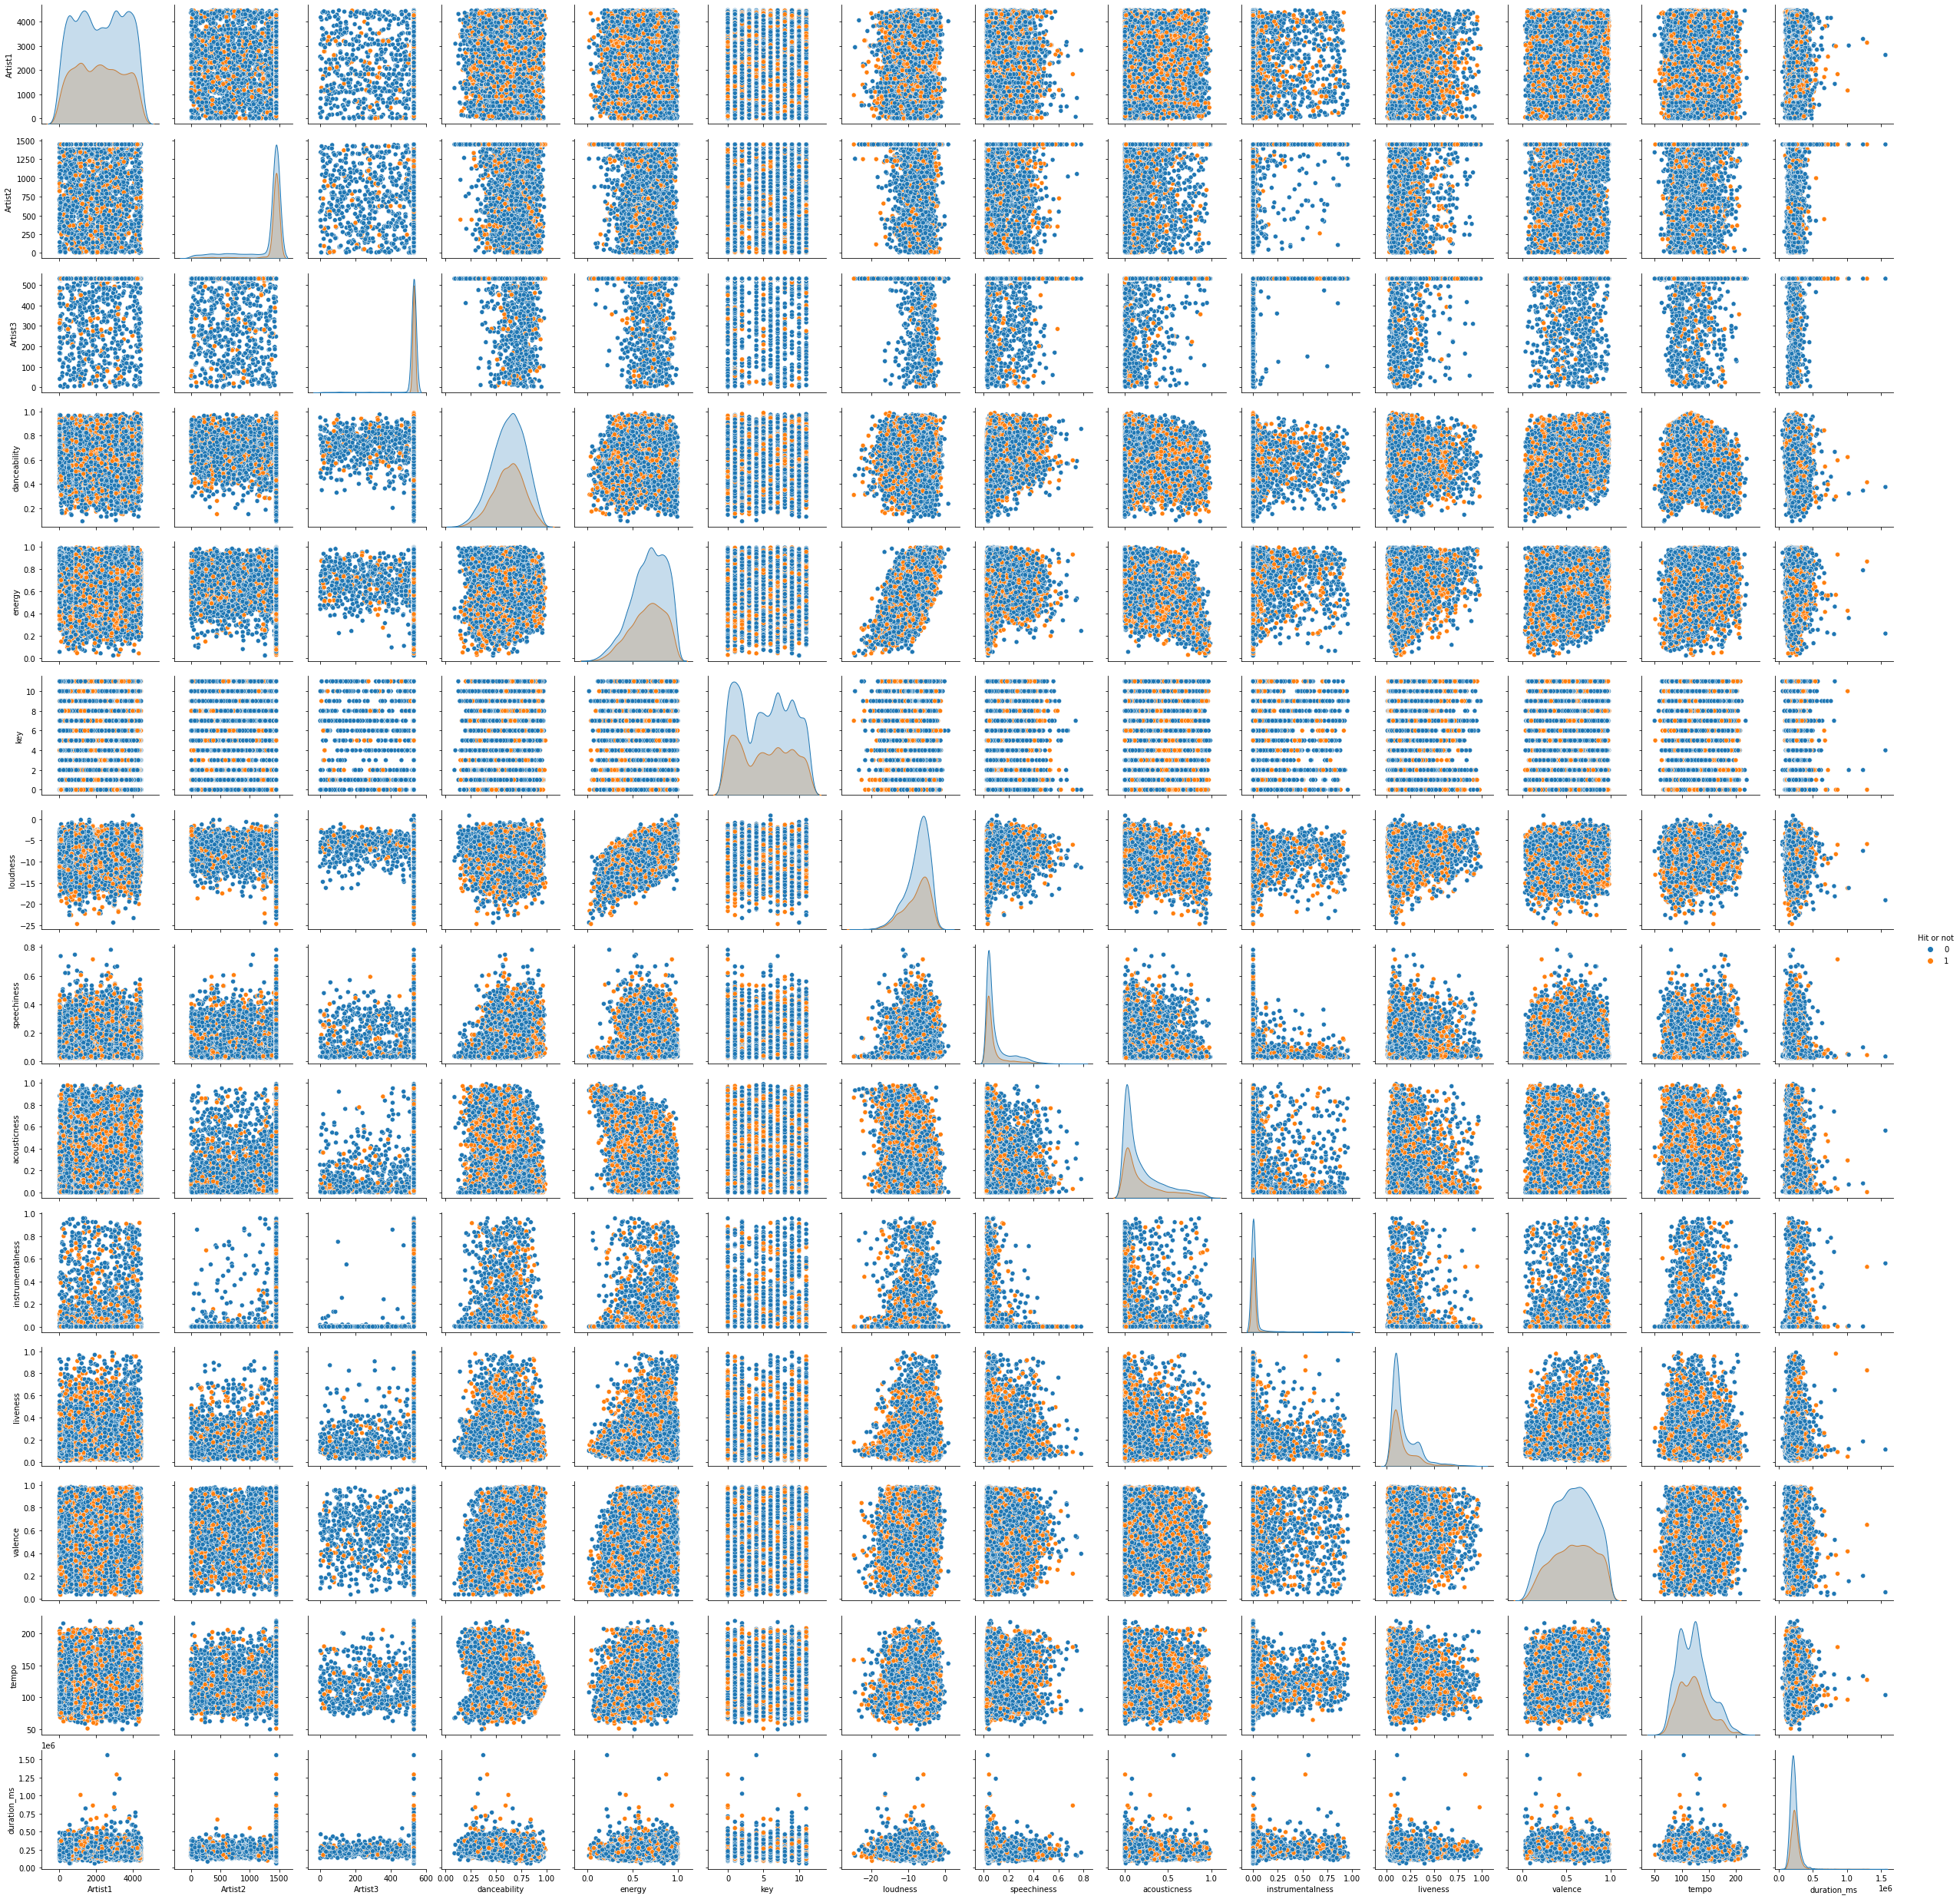

In [131]:
feature_names_pp = ['Artist1','Artist2','Artist3','danceability', 'energy', 'key', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms','Hit or not']

sns.pairplot(spotify_songs[feature_names_pp], hue='Hit or not');

Text(0.5, 1.0, 'Tempo')

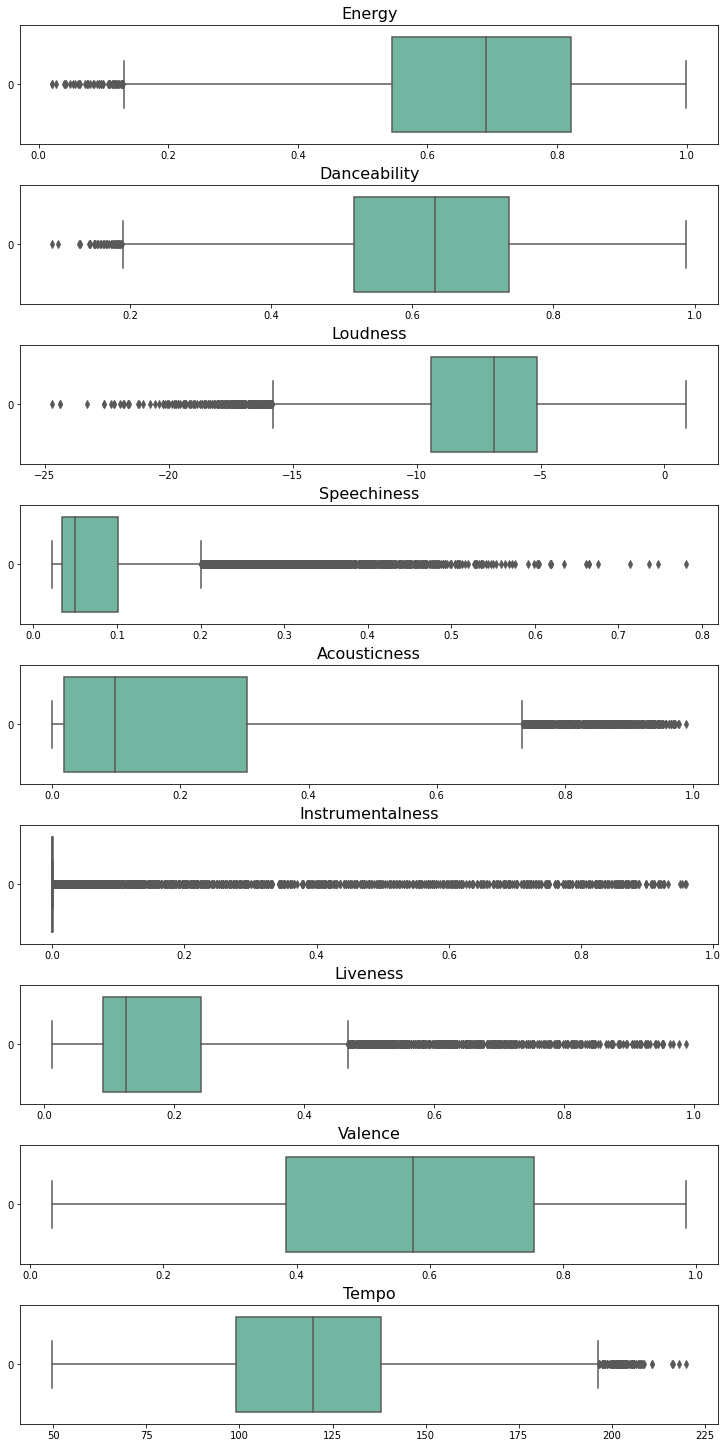

In [226]:
fig, axes = plt.subplots(9, 1,figsize=(10,20),constrained_layout=True)


feature_names_pp = ['danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

sns.boxplot(data=spotify_songs['energy'], orient="h", ax= axes[0] ,palette="Set2").set_title("Energy", fontsize=16)
sns.boxplot(data=spotify_songs['danceability'], orient="h", ax= axes[1] ,palette="Set2").set_title("Danceability", fontsize=16)
sns.boxplot(data=spotify_songs['loudness'], orient="h", ax= axes[2] ,palette="Set2").set_title("Loudness", fontsize=16)
sns.boxplot(data=spotify_songs['speechiness'], orient="h", ax= axes[3] ,palette="Set2").set_title("Speechiness", fontsize=16)
sns.boxplot(data=spotify_songs['acousticness'], orient="h", ax= axes[4] ,palette="Set2").set_title("Acousticness", fontsize=16)
sns.boxplot(data=spotify_songs['instrumentalness'], orient="h", ax= axes[5] ,palette="Set2").set_title("Instrumentalness", fontsize=16)
sns.boxplot(data=spotify_songs['liveness'], orient="h", ax= axes[6] ,palette="Set2").set_title("Liveness", fontsize=16)
sns.boxplot(data=spotify_songs['valence'], orient="h", ax= axes[7] ,palette="Set2").set_title("Valence", fontsize=16)
sns.boxplot(data=spotify_songs['tempo'], orient="h", ax= axes[8] ,palette="Set2").set_title("Tempo", fontsize=16)


# Handeling imbalance


##  1. Imbalance data with the baseline model

even though we have an imbalance dataset we first need to test its performance.. so i think logistic regression is a good model to start with. 

In [211]:
# First lets split the data 

feature_names = ['Artist1','Artist2','Artist3','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

X = spotify_songs[feature_names]
Y = spotify_songs['Hit or not']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=8)


In [80]:
#transform the data
std = StandardScaler()
std.fit(X_train.values)
X_train = std.transform(X_train.values)
X_test = std.transform(X_test.values)

In [82]:
lr = LogisticRegression(solver='liblinear')

lr.fit(X_train, Y_train)

Y_pred = lr.predict(X_test)

This is super bad.. the model is doing a terrible job at predicting the target class (Hit) but this is clearly because of the imbalance data. Also, we wont be happy with the 0.66 accuracy because it is not a good performance measure when it comes to imbalanced data 

In [83]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.67      0.98      0.79      1720
           1       0.52      0.04      0.07       881

    accuracy                           0.66      2601
   macro avg       0.59      0.51      0.43      2601
weighted avg       0.62      0.66      0.55      2601



## 2. Oversampling

### Random Oversampling

- Random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset.

- Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.

- Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

In [206]:
#taking a random sample from the 

n_hit = np.sum(Y_train == 1)
n_nothit = np.sum(Y_train == 0)
ratio = {1 : n_hit * 2, 0 : n_nothit}

ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = "not majority", random_state=42) 

X_tr_rs, y_tr_rs = ROS.fit_resample(X_train,Y_train)

We can see some improvment in the F1 score for both classes and it seems more normal.

In [85]:
lr = LogisticRegression(solver='liblinear')

lr.fit(X_tr_rs, y_tr_rs)

Y_pred = lr.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.78      0.48      0.59      1720
           1       0.42      0.73      0.53       881

    accuracy                           0.56      2601
   macro avg       0.60      0.60      0.56      2601
weighted avg       0.65      0.56      0.57      2601



 it happend because LR is not a good model for our data becuse there is litter to none linear relationship between the features and the traget,  so i will try diffrent models too 

In [86]:
# fitting as much models we want , i wont use knn too because it will perform the same as LR

lr_rs = LogisticRegression(solver='liblinear')

lr_rs.fit(X_tr_rs, y_tr_rs)

xgb_rs = XGBClassifier()

xgb_rs.fit(X_tr_rs, y_tr_rs)

rfc_rs = RandomForestClassifier()

rfc_rs.fit(X_tr_rs,y_tr_rs)

ada_rs = AdaBoostClassifier()

ada_rs.fit(X_tr_rs,y_tr_rs)


[15:52:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

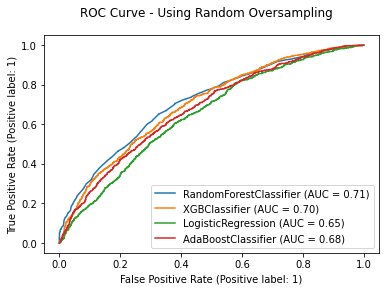

In [87]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_rs,xgb_rs,lr_rs,ada_rs]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Using Random Oversampling');

Based on the ROC graph, we can see that the AUC is the highest for the Random forset classifier and the F1 score is better. but lets try SMOT.

In [88]:
Y_pred = rfc_rs.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      1720
           1       0.58      0.40      0.47       881

    accuracy                           0.70      2601
   macro avg       0.66      0.63      0.63      2601
weighted avg       0.68      0.70      0.68      2601



### SMOT Oversampling


In [90]:
smote = imblearn.over_sampling.SMOTE(sampling_strategy='not majority', random_state = 42)

X_smote, y_smote = smote.fit_resample(X_train, Y_train)


lr_sm = LogisticRegression(solver='liblinear')

lr_sm.fit(X_smote, y_smote)

xgb_sm = XGBClassifier()

xgb_sm.fit(X_smote, y_smote)

rfc_sm = RandomForestClassifier()

rfc_sm.fit(X_smote, y_smote)

ada_sm = AdaBoostClassifier()

ada_sm.fit(X_smote, y_smote)



[15:52:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

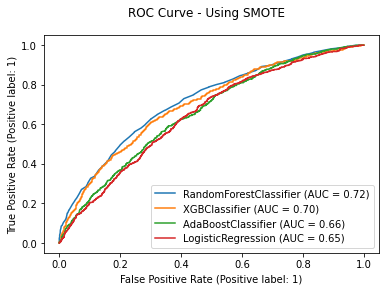

In [91]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_sm,xgb_sm,ada_sm,lr_sm]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Using SMOTE');

In [92]:
Y_pred = rfc_sm.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77      1720
           1       0.55      0.52      0.53       881

    accuracy                           0.69      2601
   macro avg       0.66      0.65      0.65      2601
weighted avg       0.69      0.69      0.69      2601



In [94]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=8)

In [95]:
rf_model = RandomForestClassifier(max_depth=7, max_features= 8,n_estimators = 500 ,random_state=42)

scores = cross_val_score(rf_model,X_smote, y_smote , scoring='roc_auc', cv=cv, n_jobs=-1)

score = np.mean(scores)

Y_pred = rf_model.fit(X_smote, y_smote).predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.79      0.58      0.67      1720
           1       0.46      0.69      0.55       881

    accuracy                           0.62      2601
   macro avg       0.62      0.64      0.61      2601
weighted avg       0.68      0.62      0.63      2601



### KMeansSMOTE

In [212]:
KNsmote = imblearn.over_sampling.KMeansSMOTE(sampling_strategy='not majority', random_state = 42)
    
X_tr_ksmote, y_tr_ksmote = KNsmote.fit_resample(X_train, Y_train)

RuntimeError: No clusters found with sufficient samples of class 1. Try lowering the cluster_balance_threshold or increasing the number of clusters.

In [ ]:
lr_ksm = LogisticRegression(solver='liblinear')

lr_ksm.fit(X_tr_ksmote, y_tr_ksmote)

xgb_ksm = XGBClassifier()

xgb_ksm.fit(X_tr_ksmote, y_tr_ksmote)

rfc_ksm = RandomForestClassifier()

rfc_ksm.fit(X_tr_ksmote, y_tr_ksmote)

ada_ksm = AdaBoostClassifier()

ada_ksm.fit(X_tr_ksmote, y_tr_ksmote)

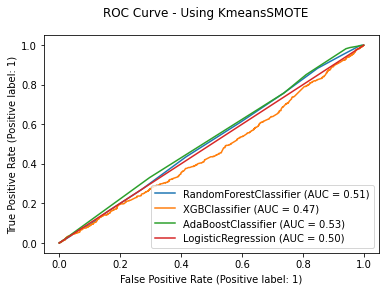

In [213]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_ksm,xgb_ksm,ada_ksm,lr_ksm]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Using KmeansSMOTE');

In [214]:
Y_pred = rfc_ksm.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.67      0.58      0.62      1720
           1       0.35      0.43      0.39       881

    accuracy                           0.53      2601
   macro avg       0.51      0.51      0.51      2601
weighted avg       0.56      0.53      0.54      2601



## 3. Undersampling 

In [100]:
under = imblearn.under_sampling.RandomUnderSampler(sampling_strategy='majority',random_state = 42)

X_tr_ur, y_tr_ur = under.fit_resample(X_train, Y_train)

In [101]:
y_tr_ur.value_counts()

0    3509
1    3509
Name: Hit or not, dtype: int64

In [102]:
lr_u = LogisticRegression(solver='liblinear')

lr_u.fit(X_tr_ur, y_tr_ur)

xgb_u = XGBClassifier()

xgb_u.fit(X_tr_ur, y_tr_ur)

rfc_u = RandomForestClassifier(random_state=42,n_estimators= 100, max_depth=10)

rfc_u.fit(X_tr_ur, y_tr_ur)

ada_u = AdaBoostClassifier()

ada_u.fit(X_tr_ur, y_tr_ur)

[15:56:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AdaBoostClassifier()

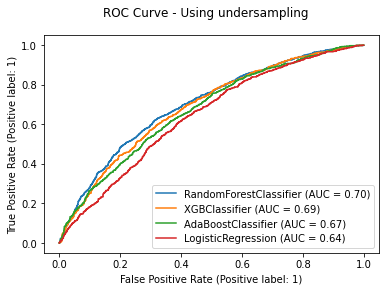

In [103]:
fig, ax1 = plt.subplots(1,1)
for mod in [rfc_u,xgb_u,ada_u,lr_u]:
    metrics.plot_roc_curve(mod, X_test, Y_test, ax=ax1)
plt.suptitle('ROC Curve - Using undersampling');

In [104]:
Y_pred = rfc_u.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.80      0.57      0.67      1720
           1       0.46      0.71      0.56       881

    accuracy                           0.62      2601
   macro avg       0.63      0.64      0.61      2601
weighted avg       0.68      0.62      0.63      2601



## undersampling without RandomUnderSampler

In [116]:
min_class_len = len(spotify_songs[spotify_songs['Hit or not']== 1])
min_class_len

4390

In [117]:
maj_class_index = spotify_songs[spotify_songs['Hit or not']== 0].index
len(maj_class_index)

8613

In [118]:
random_maj_index = np.random.choice(maj_class_index,min_class_len, replace= False)

print(len(random_maj_index))

4390


In [119]:
min_class_index = spotify_songs[spotify_songs['Hit or not']== 1].index

In [120]:
under_sample_index = np.concatenate([min_class_index,random_maj_index])

In [121]:
under_sample_df = spotify_songs.loc[under_sample_index]

In [122]:
under_sample_df['Hit or not'].value_counts()

1    4390
0    4390
Name: Hit or not, dtype: int64

In [123]:
# First lets split the data 

feature_names = ['Artist1','Artist2','Artist3','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness','acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

X = under_sample_df[feature_names]
Y = under_sample_df['Hit or not']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [124]:
#transform the data

std = StandardScaler()
std.fit(X_train.values)
X_train = std.transform(X_train.values)
X_test = std.transform(X_test.values)

In [125]:
rfc1 = RandomForestClassifier(random_state=42,n_estimators= 100, max_depth=2)

rfc1.fit(X_train, Y_train)

Y_pred = rfc1.predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.62      0.45      0.52       863
           1       0.58      0.74      0.65       893

    accuracy                           0.60      1756
   macro avg       0.60      0.59      0.59      1756
weighted avg       0.60      0.60      0.59      1756



In [126]:
rf_model = RandomForestClassifier(max_depth=7, max_features= 4,n_estimators = 500 ,random_state=42)

scores = cross_val_score(rf_model, X_train, Y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

score = np.mean(scores)

Y_pred = rf_model.fit(X_train, Y_train).predict(X_test)

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.64      0.59      0.61       863
           1       0.63      0.68      0.65       893

    accuracy                           0.63      1756
   macro avg       0.63      0.63      0.63      1756
weighted avg       0.63      0.63      0.63      1756

